# Udacity Project Machine Learning - Enron Mail Dataset

## Introduction
The goal of the project is to study a dataset of emails of a company called Enron. This company went bankrupt after a the fraud was detected.

"Enron's complex financial statements were confusing to shareholders and analysts. In addition, its complex business model and unethical practices required that the company use accounting limitations to misrepresent earnings and modify the balance sheet to indicate favorable performance." source: https://en.wikipedia.org/wiki/Enron_scandal

The information if a person is POI or not is provided by Udacity.

### Project goal
The goals of the project are:
- Get familar with dataset, clean dataset, check dataset for outliers
- Visualize dependencies of features
- Create new features (feature engineering)
- Set up ML model to indentify if a person was a "POI" or not
- Select best features to achieve a good presicion and recall score
- Tune selected model
- Validate model against test data


### Validation strategy

The validation of a model is important, because we need to know how good the model is at identifying POI from the dataset. We will use a classical train/test split of the entire dataset, which divides the data set into 70% data used to train the ML model and 30% of testing/validation data. <br>
This will allow us to check the ML model performance on data, which the model has never seen before. <br>
If we would train the model on the complete dataset, we will in most cases get a perfect validation, which is misleading. That's why validation of a ML model needs to be done on a independent set of data.

The validity of the classifier model is measured by the precision and recall scrore.
In this way we can justify the feature selection and the model hyper-parameter tuning.

"Precision is the number of correct positive classifications divided by the total number of positive labels assigned. In other words, it is the fraction of persons of interest predicted by the algorithm that are truly persons of interest. Mathematically precision is defined as" (Ref. 1) <br>

- precision = true positives / (true positives + false positives)

"Recall is the number of correct positive classifications divided by the number of positive instances that should have been identified. In other words, it is the fraction of the total number of persons of interest in the data that the classifier identifies. Mathematically, recall is defined as" (Ref. 1) <br>

- recall = true positives / (true positives + false negatives)


https://en.wikipedia.org/wiki/Precision_and_recall


### Script overview

The script "poi_id.py" and the created *.pkl files are located at the sub-folder "final_project".
The project evaluator will test these using the tester.py script.

### References:
- Ref. 1: https://medium.com/@williamkoehrsen/machine-learning-with-python-on-the-enron-dataset-8d71015be26d
- Ref. 2: https://stackoverflow.com/questions/44511636/matplotlib-plot-feature-importance-with-feature-names

In [1]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.grid_search import GridSearchCV

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

/home/niklas/Documents/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/niklas/Documents/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Task 1: Feature Selection

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list_init = ["poi", "salary", "bonus",'from_poi_to_this_person', 'from_this_person_to_poi',
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
features_list = ["poi", "salary", "bonus", 'from_poi_ratio', 'to_poi_ratio',
                 'deferral_payments', 'total_payments', 'loan_advances', #'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_rec_ratio', 'restricted_stock' ]
                 #,'director_fees']
#number of features used:
print("number of features:" , len(features_list))

('number of features:', 15)


## Data Exploration

In [4]:
# print names of all 146 individuals:
#print data_dict.keys()

In [5]:
# print entries of the first person:
print data_dict['ALLEN PHILLIP K']

{'salary': 201955, 'to_messages': 2902, 'deferral_payments': 2869717, 'total_payments': 4484442, 'exercised_stock_options': 1729541, 'bonus': 4175000, 'restricted_stock': 126027, 'shared_receipt_with_poi': 1407, 'restricted_stock_deferred': -126027, 'total_stock_value': 1729541, 'expenses': 13868, 'loan_advances': 'NaN', 'from_messages': 2195, 'other': 152, 'from_this_person_to_poi': 65, 'poi': False, 'director_fees': 'NaN', 'deferred_income': -3081055, 'long_term_incentive': 304805, 'email_address': 'phillip.allen@enron.com', 'from_poi_to_this_person': 47}


##  Data Exploration
First, I will import the dict into a pandas Dataframe, since it will make the data exploration and clean up much easier for me. <br>
According to the documentation of the enron mail dataset the NAN values of financial data are related to a 0.
This is not true for the email address, but replacing a NAN with a 0 here will not have an influence on results, since the email address is not a candidate for a feature.

In [6]:
print "Number of persons within the dataset:", len(data_dict)

Number of persons within the dataset: 146


146, but 1 value is the "total" row, which is removed later.

In [7]:
df = pd.DataFrame(data_dict)
df = df.T
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


I replace the string "NaN" with np.nan and count the nan per feature.
Some features contain many nan, but as written above this actually means 0.
For this reason I replance np.nan with 0.

In [8]:
df = df.replace('NaN', np.nan)
df.isnull().sum()

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                 35
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64

In [9]:
df = df.replace(np.nan, 0)

In [10]:
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,0.0,phillip.allen@enron.com,1729541.0,13868.0,2195.0,47.0,65.0,...,304805.0,152.0,False,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
BADUM JAMES P,0.0,178980.0,0.0,0.0,0,257817.0,3486.0,0.0,0.0,0.0,...,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,182466.0,257817.0
BANNANTINE JAMES M,0.0,0.0,-5104.0,0.0,james.bannantine@enron.com,4046157.0,56301.0,29.0,39.0,0.0,...,0.0,864523.0,False,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,0,6680544.0,11200.0,0.0,0.0,0.0,...,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
BAY FRANKLIN R,400000.0,260455.0,-201641.0,0.0,frank.bay@enron.com,0.0,129142.0,0.0,0.0,0.0,...,0.0,69.0,False,145796.0,-82782.0,239671.0,0.0,0.0,827696.0,63014.0


### Task 2: Remove outliers
The total entry is obviously an outlier, which will be droped from the dataframe

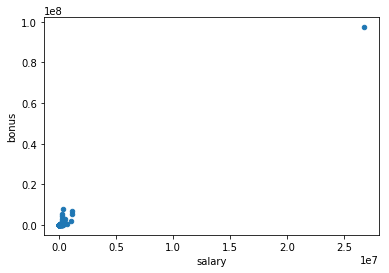

In [11]:
df.plot('salary','bonus',kind = 'scatter')

In [12]:
df[df['bonus']==df['bonus'].max()]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,0,311764000.0,5235198.0,0.0,0.0,0.0,...,48521928.0,42667589.0,False,130322299.0,-7576788.0,26704229.0,0.0,0.0,309886585.0,434509511.0


The "total" row is an obvious outlier and will be removed.

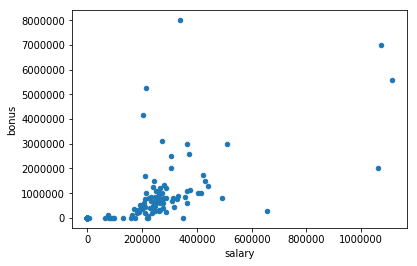

In [13]:

df = df.drop(['TOTAL'])
data_dict.pop('TOTAL', 0)
df.plot('salary','bonus',kind = 'scatter')

In [14]:
# count number of POI/non-POI
df['poi'].value_counts()

False    127
True      18
Name: poi, dtype: int64

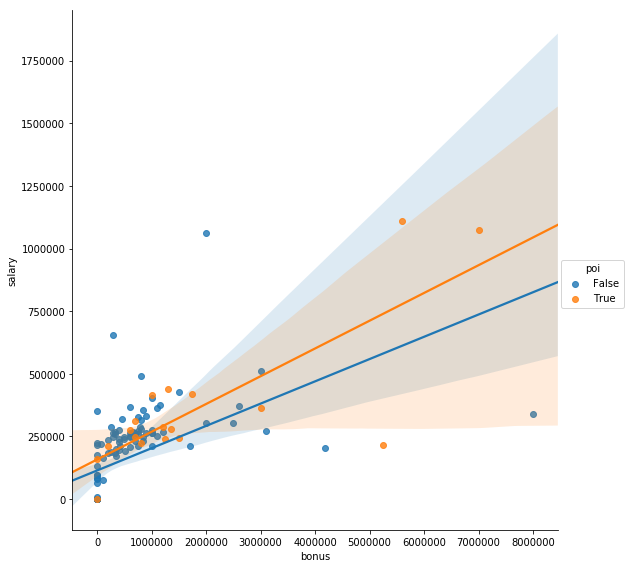

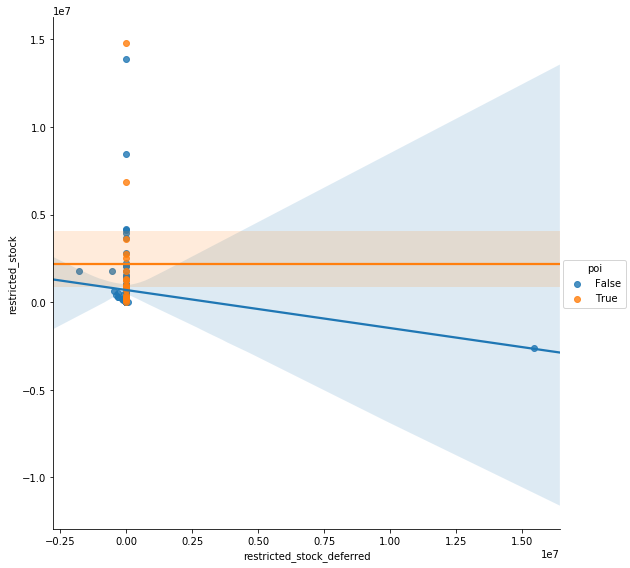

In [15]:
#sns.pairplot(df, vars=['salary', 'total_payments'], hue= 'poi', size = 5)
sns.lmplot(data = df, x = 'bonus', y = 'salary', hue = 'poi', size = 8)
sns.lmplot(data = df, x = 'restricted_stock_deferred', y = 'restricted_stock', hue = 'poi', size = 8)

In [16]:
# looking at the graph above, I think the feature "restricted_stock_deferred" is irrelevant to identify poi, and will decrease accuracy.
# Indeed, by removing this feature I increased the score from 0.66 to 0.91.
df[df['restricted_stock_deferred']==df['restricted_stock_deferred'].max()]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,0.0,137864.0,False,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0


## Task 3: Create new feature(s)

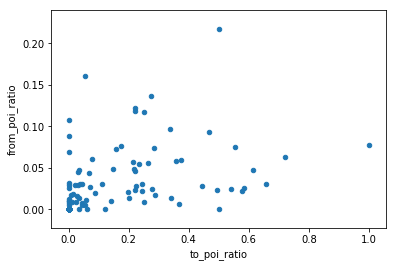

In [17]:
### Task 3: Create new feature(s)

#Note that I only create some new features fot the sake of the project submission. 
#At the end I will use a decision tree classifier, so scaling does not influence results.

df['from_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df['to_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']
df['shared_rec_ratio'] = df['shared_receipt_with_poi'] / df['to_messages']
df = df.fillna(0)
df.plot('to_poi_ratio','from_poi_ratio',kind = 'scatter')


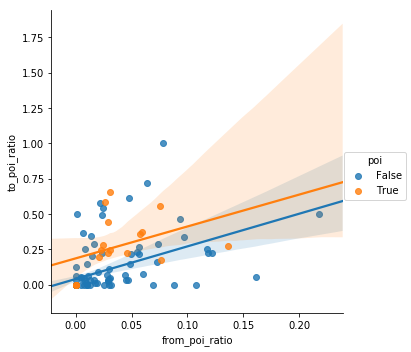

In [18]:
sns.lmplot(data = df, x = 'from_poi_ratio', y = 'to_poi_ratio', hue = 'poi', size = 5)

In the following lines of code I convert the pandas dataframe back to a dict, since the tester.py script expects this format.

In [19]:
### Store to my_dataset for easy export below.
#my_dataset = data_dict
my_dataset = df.to_dict(orient='index')

### Extract features and labels from dataset for local testing
#data = featureFormat(my_dataset, features_list_init, sort_keys = True)
#labels, features = targetFeatureSplit(data)
labels_df = df['poi']
features_df = df[features_list].drop(['poi'], axis = 1)


## Task 4: Try a varity of classifiers

In [20]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.

features_train, features_test, labels_train, labels_test = \
    train_test_split(features_df, labels_df, test_size=0.3, random_state=42)
#features_train, features_test, labels_train, labels_test = \
#    train_test_split(features, labels, test_size=0.3, random_state=42)


from sklearn.svm import SVC
clf = SVC()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test, pred)
prec = precision_score(labels_test, pred)
recall = recall_score(labels_test, pred)
print "SVC accuracy score:","%.2f" % round(accuracy,3) , "precision:","%.2f" % round(prec,3), "recall:","%.2f" % round(recall,3)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=2)
clf_select = clf
clf.fit(features_train,labels_train)
clf_select.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test, pred)
prec = precision_score(labels_test, pred)
recall = recall_score(labels_test, pred)
print "DTC accuracy score:","%.2f" % round(accuracy,3) , "precision:","%.2f" % round(prec,3), "recall:","%.2f" % round(recall,3)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=2)
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test, pred)
prec = precision_score(labels_test, pred)
recall = recall_score(labels_test, pred)

print "RFC accuracy score:","%.2f" % round(accuracy,3) , "precision:","%.2f" % round(prec,3), "recall:","%.2f" % round(recall,3)

print confusion_matrix(labels_test, pred)

SVC accuracy score: 0.91 precision: 0.00 recall: 0.00
DTC accuracy score: 0.86 precision: 0.33 recall: 0.50
RFC accuracy score: 0.91 precision: 0.50 recall: 0.50
[[38  2]
 [ 2  2]]


/home/niklas/Documents/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### pick an algorithm
Initially, the DTC did perform best, so I have choosen this model for further fine tuning.
Note that the initial precision and recall score of the RFC was worse than the DTC.
This changed after removing the 'directors fee' featuire from the list.


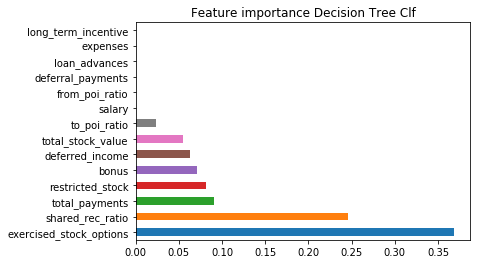

In [21]:
#plot the feature importances of random decision tree classifier
(pd.Series(clf_select.feature_importances_, index=features_train.columns)
   .nlargest(15)
   .plot(kind='barh',title="Feature importance Decision Tree Clf"))

## Task 5: Tune the classifier 
The precision and recall rate of the decision tree classifier is quite promising, and I will try to tune it in this chapter.

In [22]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

clf = DecisionTreeClassifier(max_depth=None,min_samples_split=2,max_features=8,random_state=2)
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test, pred)
prec = precision_score(labels_test, pred)
recall = recall_score(labels_test, pred)
print "DTC accuracy score:","%.2f" % round(accuracy,3) , "precision:","%.2f" % round(prec,3), "recall:","%.2f" % round(recall,3)


print confusion_matrix(labels_test, pred)


DTC accuracy score: 0.86 precision: 0.33 recall: 0.50
[[36  4]
 [ 2  2]]


#### usage of evaluation metrics
I have tuned the model in a way that it can correctly predict 2 of 4 POI of the test data set. (recall score)
On the other hand, 3 persons were wrongly labeled as POI by the model, resulting in a precision score of 0.4.

#### discussion of parameter tuning
By changing the hyper-parameter 'max_features' to 8 I could increase the precision score from 0.25 to 0.31 and the recall score from 0.25 to 0.33.
Comparing the feature importance plots before and after tuning indicates that this change had also an impact on the weight of the features. The most important feature still remains "exercised stock options" followed by "shared receipt ratio".

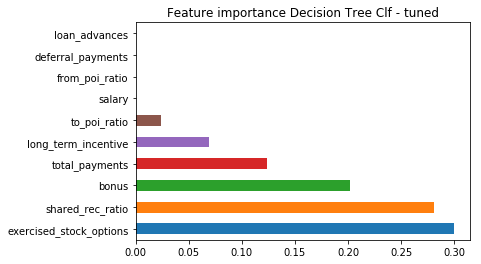

In [23]:
(pd.Series(clf.feature_importances_, index=features_train.columns)
   .nlargest(10)
   .plot(kind='barh',title="Feature importance Decision Tree Clf - tuned"))

In [24]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
dump_classifier_and_data(clf, my_dataset, features_list)